# Autoregressive Integrated Moving Average (ARIMA)


Seri durağan olduğunda tahmin edilmesi daha kolaydır.

Bir ARIMA modelinde, farkları kullanarak bir zaman serisini durağan hale dönüştürürüz.
Durağan zaman serisi: trend veya mevsimsellik içermeyen, ortalama ve varyansın zaman içinde sabit olduğu seridir. 
Fark alma, durağan olmayan bir zaman serisini durağan hale dönüştürme yöntemidir. Tahmin için verilerin hazırlanmasında önemli bir adımdır.

D = Zaman serisinin durağan hale gelmesi için gereken fark alma dönüşümlerinin sayısını ifade eder.

İlk fark değeri, mevcut zaman periyodu ile önceki zaman periyodu arasındaki farktır.
Bu değerler sabit bir ortalama ve varyans etrafında dönmezse, o zaman ilk farkın değerlerini kullanarak ikinci farkı buluruz.
Bunu durağan bir seri elde edene kadar tekrarlıyoruz.
(Serinin yeterince farklı olup olmadığını belirlemenin en iyi yolu, farkı alınmış seriyi çizmek ve sabit bir ortalama ve varyans olup olmadığını kontrol etmektir.)

**Dickey-Fuller testi:** bir serinin durağan olup olmadığını belirlemek için:
p-değeri <= 0.05: (%5) ise verinin birim kök içermediği ve durağan olduğu anlamına gelir. 

Q = Bu değişken, hata bileşeninin gecikmesini belirtir; buradaki hata bileşeni, zaman serisinin trend veya mevsimsellikle ilgili olmayan parçasıdır.

Otokorelasyon fonksiyon grafiği (ACF): Otokorelasyon, bir zaman serisinin geçmiş değerleriyle ne kadar ilişkili olduğunu ifade eden, gecikme birimi dahil olmak üzere noktalar arasındaki korelasyonu görmek için kullanılan bir çizimdir.
ACF'de korelasyon katsayısı (x) eksenindeyken gecikme sayısı (y) ekseninde gösterilir.
Otokorelasyon fonksiyon grafiği, verilen zaman serisinin kendisiyle nasıl ilişkili olduğu hakkında bilgi verir.

In [64]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
#sb.set_style("whitegrid")
plt.style.use('seaborn-poster')
plt.rcParams["figure.figsize"] = (15,7)

from scipy import stats
import statsmodels.api as sm
from itertools import product
from datetime import datetime
import missingno as msno
import datetime
from datetime import timedelta

import warnings
warnings.filterwarnings("ignore")

import pickle, joblib
from keras.models import load_model    #  to pickle DL large files
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults


## PRECODE SECTION

In [65]:
# MODELSELECTION
# Initial approximation of parameters

def model_select(dffeature_box,value):
  Qs = range(0, 2)
  qs = range(0, 3)
  Ps = range(0, 3)
  ps = range(0, 3)
  D=1
  d=1
  parameters = product(ps, qs, Ps, Qs)
  parameters_list = list(parameters)
  len(parameters_list)

  # Model Selection
  results = []
  best_aic = float("inf")
  warnings.filterwarnings('ignore')
  for param in parameters_list:
      try:
          model=sm.tsa.statespace.SARIMAX(dffeature_box, order=(param[0], d, param[1]), 
                seasonal_order=(param[2], D, param[3], value)).fit(disp=-1)
      except ValueError:
          print('wrong parameters:', param)
          continue
      aic = model.aic
      if aic < best_aic:
          best_model = model
          best_aic = aic
          best_param = param
      results.append([param, model.aic])

  # Best Models
  result_table = pd.DataFrame(results)
  result_table.columns = ['parameters', 'aic']
  print(result_table.sort_values(by = 'aic', ascending=True).head())
  print(best_model.summary())

In [66]:
#Calculating the evals
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def eval_metrics(actual, pred):
    mae =int(mean_absolute_error(actual, pred))
    mse =int(mean_squared_error(actual, pred))
    rmse = int(np.sqrt(mean_squared_error(actual, pred)))
    R2_score =np.round(r2_score(actual, pred),2)
    print("------------------------------------")
    print(f"R2_score \t: {R2_score}")
    print(f"MAE \t\t: {mae}")
    #print(f"MSE \t\t: {mse}")
    print(f"RMSE \t\t: {rmse}")
def evals_():
    print("y_train / y_train_pred ")
    eval_metrics(y_train, y_train_pred)
    #print("y_test / y_test_pred ")
    #eval_metrics(y_test, y_test_pred)
def rms_() :   #  RMS
    trainscore = int(math.sqrt(mean_squared_error(y_train, y_train_pred)))
    print("Train Score: %.f RMSE" % (trainscore))
    #testscore = int(math.sqrt(mean_squared_error(y_test, y_test_pred)))
    #print("Test Score: %.f RMSE" % (testscore))

# Visualising the results
def ploty(real,predicted,ttitle)  :
    plt.figure(figsize=(15,7))
    plt.plot(real,      color = 'blue' , label = '  Real  '   )   # Real Sales
    plt.plot(predicted, color = 'red', label = '  Predicted ',ls='--'  )
    plt.xlabel('Date') ; plt.ylabel(' Total Euro') ; plt.legend()
    plt.title(ttitle)
    plt.show()
def plot_():
    #ploty(y_train,y_train_pred)    # TRAIN
    ploty(y_test,y_test_pred)       # TEST

In [67]:
# Prediction

# test=df_month['Total']
# date_list = [datetime(2022, 5, 31), datetime(2022, 6, 30), datetime(2022,7, 31)]
# start=
# end=
# ttitle=
def predict(test,date_list,start,end,ttitle):
  aa = pd.DataFrame(test)
  future = pd.DataFrame(index=date_list, columns= aa.columns)
  bb = pd.concat([aa, future])
  bb['forecast'] = invboxcox(best_model.predict(start=start, end=end), lmbda)
  test_=bb     # we save it to use it later, in a different place
  ploty(aa,bb["forecast"],ttitle)

# MAIN SECTION

In [68]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [69]:
from google.colab.data_table import DataTable
DataTable.max_columns = 14

In [70]:
ar=pd.read_excel("/content/drive/MyDrive/ColabNotebooks/Internship/Group2/Sumdata_salevali_concat.xlsx")
df=ar.copy()
df.head()

,Unnamed: 0,Invoice_number,Date,Marketplace,Product_explanation,Amount,Unit_price,Total,Shipping_cost,category,inflation,day_of_week
0,0,KundenID17342,2022-04-29,Amazon,pistazien baklava (1250 gr spezielle quadratis...,1.0,22.15,22.15,4.90,Turkish Deserts,7.4,Friday
1,1,KundenID3283,2022-04-29,Wocommerce,dogal ezine peyniri/ kaliteli ve lezzetli orga...,1.0,3.79,3.79,0.00,Milk Product,7.4,Friday
2,2,KundenID7914,2022-04-29,Amazon,haselnusse in der schale (10 kg) |haselnuss /i...,1.0,65.41,65.41,4.90,Nuts,7.4,Friday
3,3,KundenID11236,2022-04-29,Wocommerce,kurutulmus kivi halkalari - 500 gr.,1.0,6.73,6.73,0.00,Dried Fruit and Vegatable,7.4,Friday
4,4,KundenID1932,2022-04-29,Amazon,ajwa datteln |premium frisch datteln aus arabi...,1.0,55.13,55.13,6.85,Date,7.4,Friday


In [71]:
df.tail(10)

,Unnamed: 0,Invoice_number,Date,Marketplace,Product_explanation,Amount,Unit_price,Total,Shipping_cost,category,inflation,day_of_week
39642,39642,281,2017-09-11,WOCOMMERCE,bio flower honig - direktimport vom bio erzeug...,1.0,8.40,8.40,0.0,Honey,1.7,Monday
39643,39643,282,2017-09-06,WOCOMMERCE,3 stuck bio lavendel honig - direktimport vom ...,1.0,20.56,20.56,0.0,Honey,1.7,Wednesday
39644,39644,283,2017-09-01,EBAY,bio lavendel honig - direktimport vom bio erze...,1.0,11.68,11.68,0.0,Honey,1.7,Friday
39645,39645,2,2017-08-29,B2B,almaoliva aove pet 30 ml,20.0,0.50,10.00,0.0,Olive Oil,1.6,Tuesday
39646,39646,2,2017-08-29,B2B,parqueoliva aove dop marasca transparente 20 ml,20.0,0.50,10.00,0.0,Olive Oil,1.6,Tuesday
39647,39647,2,2017-08-29,B2B,almaoliva aove bio marasca 500 ml,10.0,2.00,20.00,0.0,Olive Oil,1.6,Tuesday
39648,39648,2,2017-08-29,B2B,parqueoliva serie oro aove dop almazaras 500 ml,2.0,4.10,8.20,0.0,Olive Oil,1.6,Tuesday
39649,39649,2,2017-08-29,B2B,almaoliva aove arbequino almazaras 500 ml,2.0,4.10,8.20,0.0,Olive Oil,1.6,Tuesday
39650,39650,2,2017-08-29,B2B,royal extra 250 ml,10.0,1.30,13.00,0.0,Olive Oil,1.6,Tuesday
39651,39651,2,2017-08-29,B2B,duque baena aove 250 ml,10.0,1.30,13.00,0.0,Olive Oil,1.6,Tuesday


* Bazı günlerde hiç kayıt yok, muhtemelen hiç satış olmamış Örnek 2017-08-30, 2017-08-31, 2017-09-02  ..03,..-04,..05

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39652 entries, 0 to 39651
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Unnamed: 0           39652 non-null  int64         
 1   Invoice_number       39652 non-null  object        
 2   Date                 39652 non-null  datetime64[ns]
 3   Marketplace          39652 non-null  object        
 4   Product_explanation  39652 non-null  object        
 5   Amount               39652 non-null  float64       
 6   Unit_price           39652 non-null  float64       
 7   Total                39652 non-null  float64       
 8   Shipping_cost        39652 non-null  float64       
 9   category             39652 non-null  object        
 10  inflation            39652 non-null  float64       
 11  day_of_week          39652 non-null  object        
dtypes: datetime64[ns](1), float64(5), int64(1), object(5)
memory usage: 3.6+ MB


In [73]:
df.index = df.Date

In [74]:
df.head(2)

,Unnamed: 0,Invoice_number,Date,Marketplace,Product_explanation,Amount,Unit_price,Total,Shipping_cost,category,inflation,day_of_week
Date,,,,,,,,,,,,
2022-04-29,0,KundenID17342,2022-04-29,Amazon,pistazien baklava (1250 gr spezielle quadratis...,1.0,22.15,22.15,4.9,Turkish Deserts,7.4,Friday
2022-04-29,1,KundenID3283,2022-04-29,Wocommerce,dogal ezine peyniri/ kaliteli ve lezzetli orga...,1.0,3.79,3.79,0.0,Milk Product,7.4,Friday


In [75]:
df=df[["Total"]]

In [76]:
df.head()

,Total
Date,
2022-04-29,22.15
2022-04-29,3.79
2022-04-29,65.41
2022-04-29,6.73
2022-04-29,55.13


In [77]:
df_day= df.resample('D').mean().round(2)

In [78]:
len(df_day)

1705

*** İlk satışın gerçekleştiği günden veri setinin sonu günü dahil aradaki toplam gün sayısı: 1705

In [79]:
df_day.head()

,Total
Date,
2017-08-29,11.77
2017-08-30,NaN
2017-08-31,NaN
2017-09-01,11.68
2017-09-02,NaN


In [80]:
df_day.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1705 entries, 2017-08-29 to 2022-04-29
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Total   1019 non-null   float64
dtypes: float64(1)
memory usage: 26.6 KB


* Satış kaydı olan günlerin toplam sayısı 1019

In [81]:
# Percentage of missing values
df_day.isnull().mean().round(2).mul(100)

Total    40.0
dtype: float64

*** Satış kaydı olmayan toplam günler, toplam gün sayısının (1705) Yüzde 40.0 ını karşılık geliyor


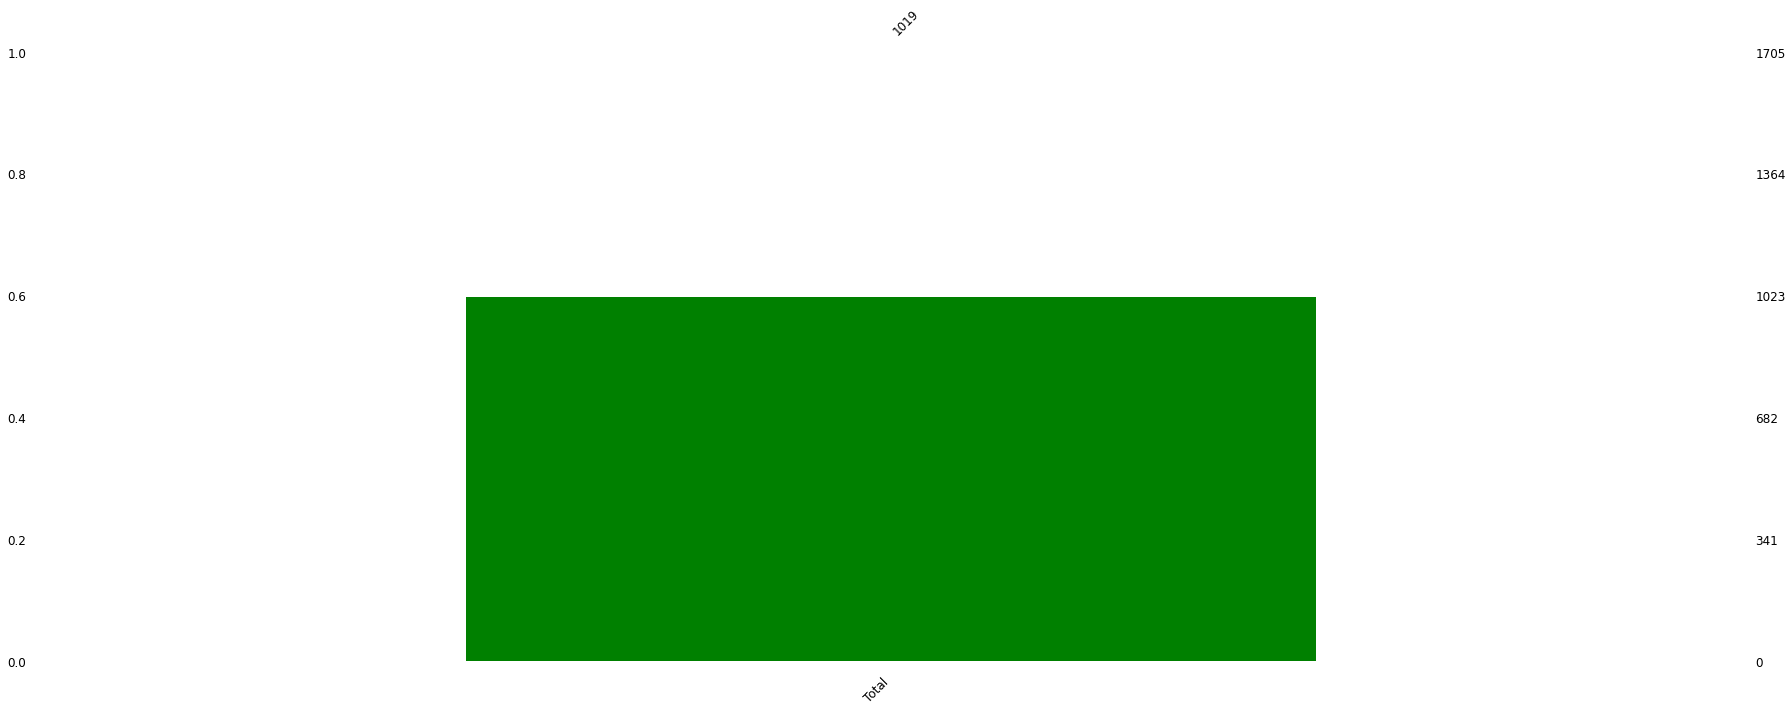

In [82]:
fig = plt.figure(figsize=[15, 7])
msno.bar(df_day,color="green", fontsize=12)
plt.tight_layout()
plt.show()

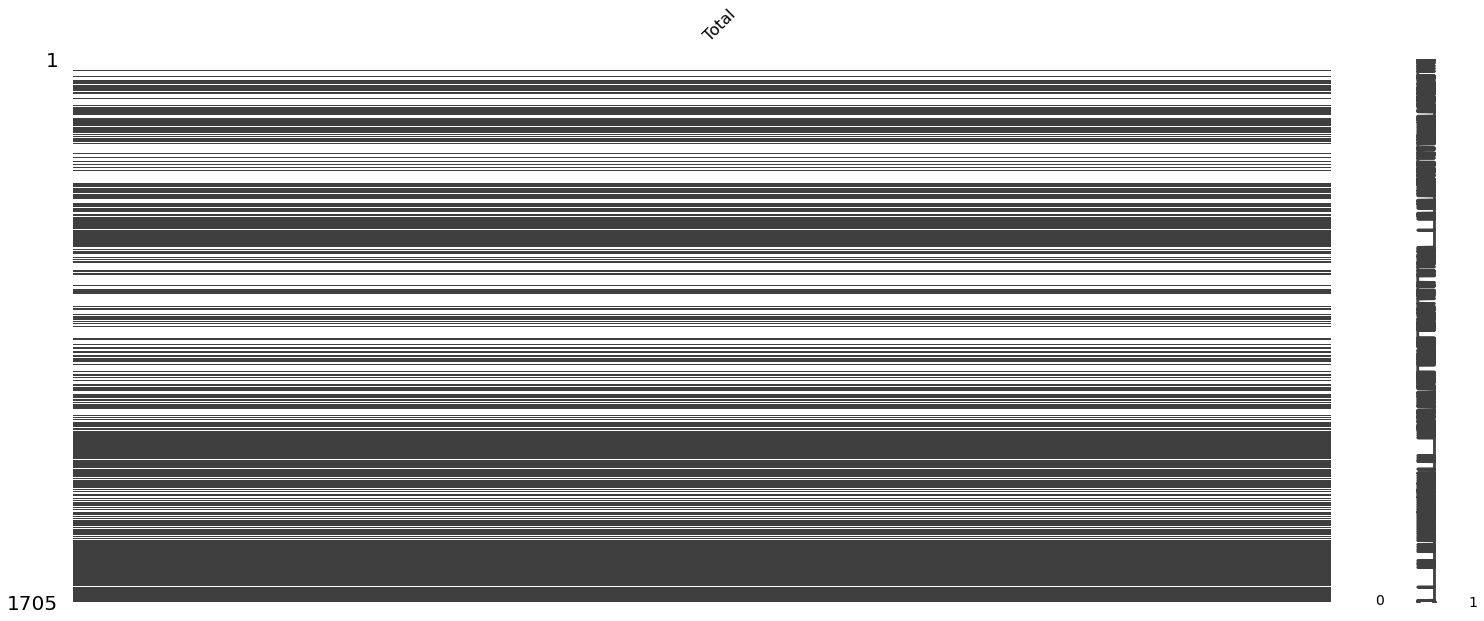

In [83]:
# Gives positional information of the missing values

msno.matrix(df_day)


*** Satış kaydı bulunmayan günler grafikte boş (beyaz) olarak gösterilmiştir. 1 ilk günü 1705 son günü temsil eder

In [84]:
# Resampling to daily frequency
df_day= df.resample('D').sum()

# Resampling to weekly frequency
df_week = df_day.resample('W').sum()

# Resampling to monthly frequency
df_month = df_day.resample('M').sum()

# Resampling to quarterly frequency
df_Q = df_day.resample('Q-DEC').sum()

# Resampling to annual frequency
df_year = df_day.resample('A-DEC').sum()

In [85]:
df_day.isin([0]).sum()

Total    686
dtype: int64

*** Toplam 686 gün kayıt yok

In [86]:
df_week.isin([0]).sum()

Total    14
dtype: int64

*** 14 haftaya ait satış kaydı bulunmuyor

In [87]:
df_month.isin([0]).sum()

Total    0
dtype: int64

*** Her ay satış kaydı var

In [88]:
# replace zeros with non zero value
df_day.replace(to_replace=0, value =0.1, inplace=True)

In [89]:
df_day.isin([0]).sum()

Total    0
dtype: int64

### Gün düzelidiğinden, diğerlerini de (hafta,ay, çeyrek, yıl) de düzeltmek için da gün üzerinden yeniden oluşturalım.

In [90]:
# Resampling to weekly frequency
df_week = df_day.resample('W').sum()

# Resampling to monthly frequency
df_month = df_day.resample('M').sum()

# Resampling to quarterly frequency
df_Q = df_day.resample('Q-DEC').sum()

# Resampling to annual frequency
df_year = df_day.resample('A-DEC').sum()

In [91]:
df_day.tail(2)

,Total
Date,
2022-04-28,3357.28
2022-04-29,2078.15


In [92]:
df_week.tail(2)

,Total
Date,
2022-04-24,16863.31
2022-05-01,10824.76


In [93]:
df_month.tail(2)

,Total
Date,
2022-03-31,72152.11
2022-04-30,84919.03


In [94]:
df_Q.tail(2)

,Total
Date,
2022-03-31,146521.26
2022-06-30,84919.03


In [95]:
df_year.tail(2)

,Total
Date,
2021-12-31,368728.26
2022-12-31,231440.29


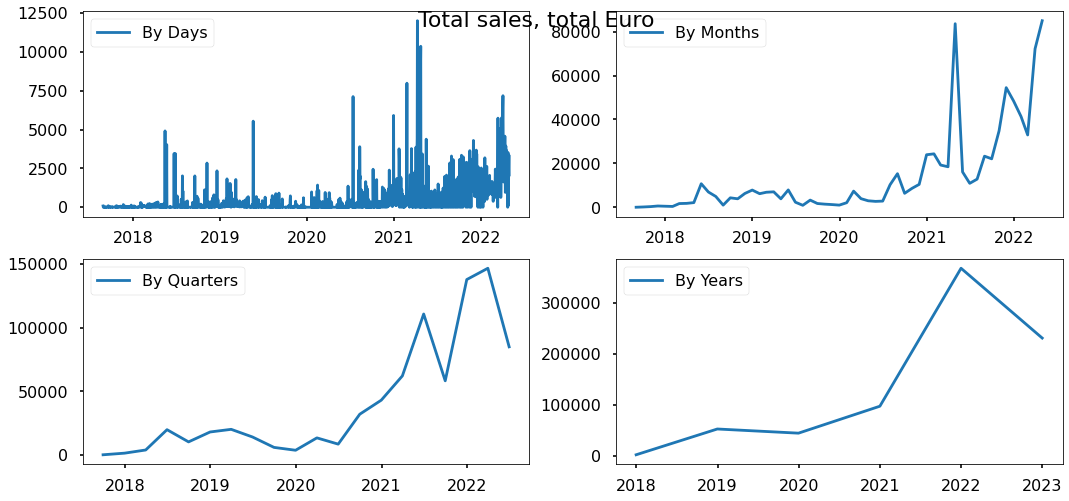

In [96]:
# PLOTS
fig = plt.figure(figsize=[15, 7])
plt.suptitle('Total sales, total Euro', fontsize=22)
plt.subplot(221)
plt.plot(df_day, '-', label='By Days')
plt.legend()
plt.subplot(222)
plt.plot(df_month, '-', label='By Months')
plt.legend()
plt.subplot(223)
plt.plot(df_Q, '-', label='By Quarters')
plt.legend()
plt.subplot(224)
plt.plot(df_year, '-', label='By Years')
plt.legend()
plt.tight_layout()
plt.show()

# Let's predict Total sales by months.

## Stationarity check and STL-decomposition of the series

<Figure size 1080x504 with 0 Axes>

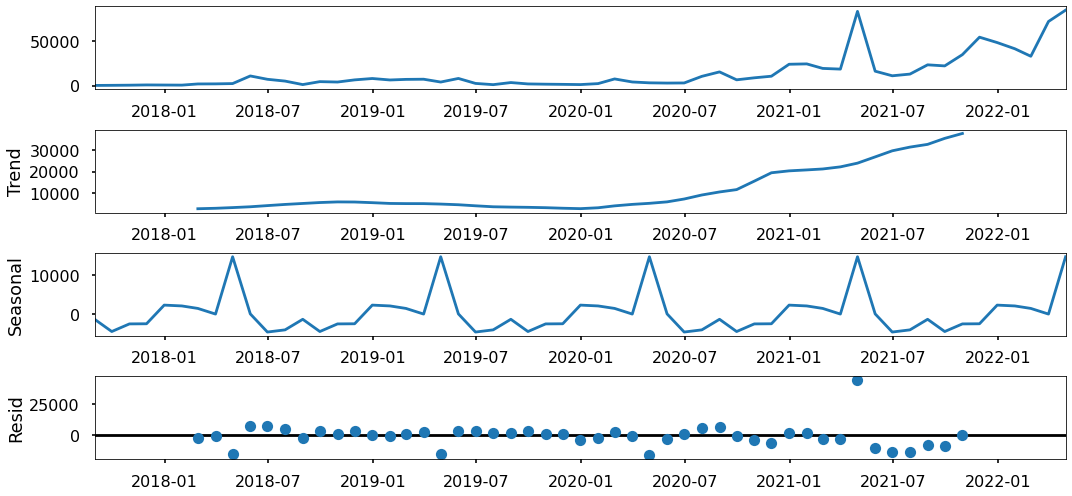

In [97]:
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(df_month).plot()
plt.show()

In [98]:
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month)[1])

Dickey–Fuller test: p=0.994197


#### Seriler durağan değil.

## Box-Cox Transformations

In [99]:
# Box-Cox Transformations
df_month['Total_box'], lmbda = stats.boxcox(df_month.Total)
df_month.tail(2)

,Total,Total_box
Date,,
2022-03-31,72152.11,19.409593
2022-04-30,84919.03,19.863270


In [100]:
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Total_box)[1])

Dickey–Fuller test: p=0.759826


#### Seriler durağan değil.



## Seasonal differentiation

In [101]:
# Seasonal differentiation
df_month['prices_box_diff'] = df_month.Total_box - df_month.Total_box.shift(12)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff[12:])[1])

Dickey–Fuller test: p=0.118795


#### Seriler durağan


## Regular differentiation

In [102]:
# Regular differentiation
df_month['prices_box_diff2'] = df_month.prices_box_diff - df_month.prices_box_diff.shift(1)
df_month.head(15)

,Total,Total_box,prices_box_diff,prices_box_diff2
Date,,,,
2017-08-31,82.60,5.430695,NaN,NaN
2017-09-30,203.85,6.836891,NaN,NaN
2017-10-31,367.91,7.820395,NaN,NaN
2017-11-30,648.37,8.815150,NaN,NaN
2017-12-31,540.03,8.488549,NaN,NaN
2018-01-31,438.90,8.124664,NaN,NaN
2018-02-28,1754.31,10.691583,NaN,NaN
2018-03-31,1843.53,10.789614,NaN,NaN
2018-04-30,2182.44,11.126444,NaN,NaN


In [103]:
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff2[13:])[1])

Dickey–Fuller test: p=0.433680


#### Seriler durağan değil


In [104]:
# Regular differentiation
df_month['prices_box_diff3'] = df_month.prices_box_diff2 - df_month.prices_box_diff2.shift(1)
df_month.head(15)

,Total,Total_box,prices_box_diff,prices_box_diff2,prices_box_diff3
Date,,,,,
2017-08-31,82.60,5.430695,NaN,NaN,NaN
2017-09-30,203.85,6.836891,NaN,NaN,NaN
2017-10-31,367.91,7.820395,NaN,NaN,NaN
2017-11-30,648.37,8.815150,NaN,NaN,NaN
2017-12-31,540.03,8.488549,NaN,NaN,NaN
2018-01-31,438.90,8.124664,NaN,NaN,NaN
2018-02-28,1754.31,10.691583,NaN,NaN,NaN
2018-03-31,1843.53,10.789614,NaN,NaN,NaN
2018-04-30,2182.44,11.126444,NaN,NaN,NaN


<Figure size 1080x504 with 0 Axes>

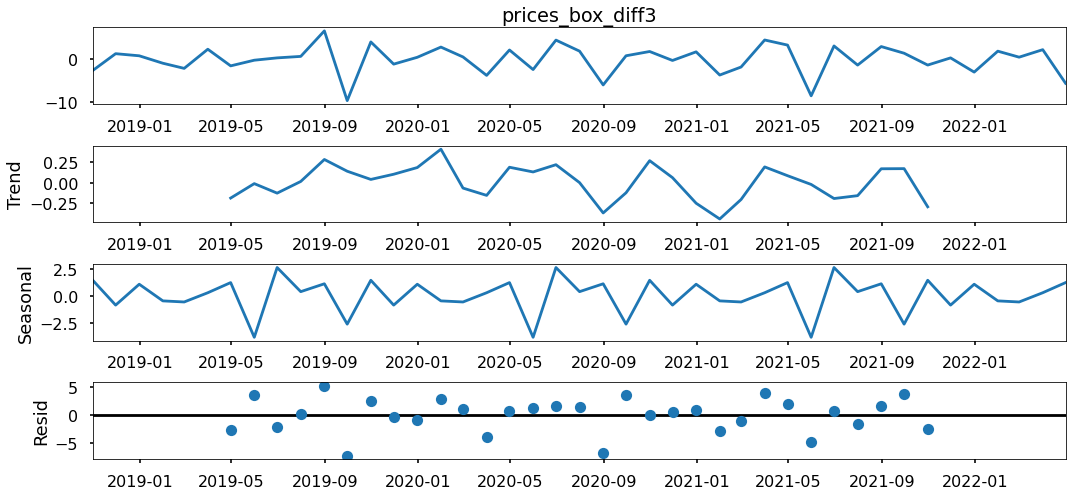

In [105]:
# STL-decomposition
plt.figure(figsize=(15,7))
sm.tsa.seasonal_decompose(df_month.prices_box_diff3[14:]).plot()   
plt.show()

In [106]:
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff3[14:])[1])

Dickey–Fuller test: p=0.000000


#### Seriler  durağan


## ACF Autocorrelation Function Plot

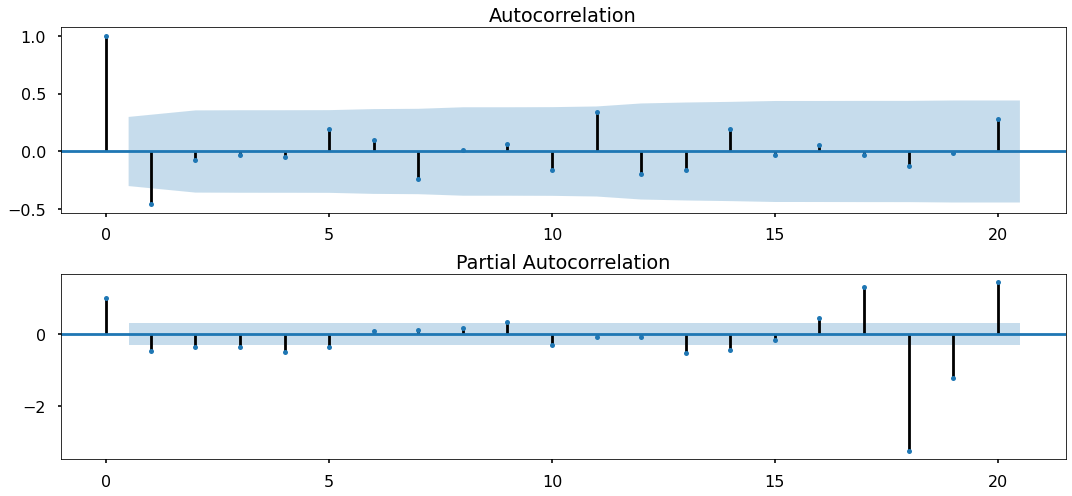

In [107]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df_month.prices_box_diff3[14:].values.squeeze(), lags=20, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df_month.prices_box_diff3[14:].values.squeeze(), lags=20, ax=ax)
plt.tight_layout()
plt.show()

## Model Selection

In [108]:
# model_select(df_month.Total_box,4)

In [109]:
## Model Selection
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df_month.Total_box, order=(param[0], d, param[1]), 
              seasonal_order=(param[2], D, param[3], 4)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [110]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters         aic
7   (0, 1, 0, 1)  206.709719
13  (0, 2, 0, 1)  207.209559
25  (1, 1, 0, 1)  207.549049
37  (2, 0, 0, 1)  208.182380
19  (1, 0, 0, 1)  208.470931
                                     SARIMAX Results                                     
Dep. Variable:                         Total_box   No. Observations:                   57
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 4)   Log Likelihood                -100.355
Date:                           Thu, 06 Oct 2022   AIC                            206.710
Time:                                   17:35:25   BIC                            212.563
Sample:                               08-31-2017   HQIC                           208.954
                                    - 04-30-2022                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------

## Analysis of residues

Dickey–Fuller test:: p=0.000002


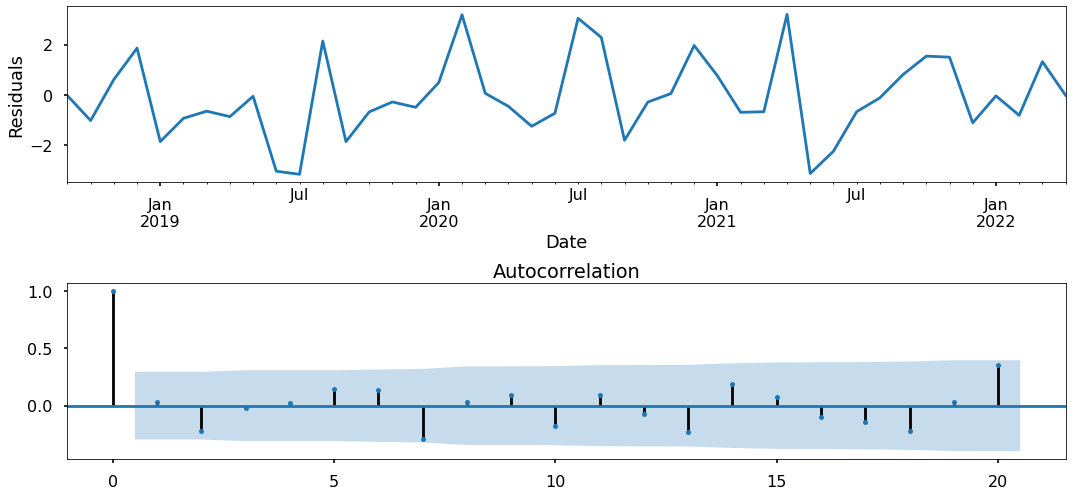

In [111]:
# STL-decomposition
plt.figure(figsize=(15,7))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=20, ax=ax)

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

plt.tight_layout()
plt.show()

In [112]:
print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Dickey–Fuller test:: p=0.000002


# Prediction

In [113]:
Length=len(df_month)
Length

57

In [114]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

In [115]:
train=df_month

In [116]:
# Gelecek 6 ay  için tarihleri oluşturalım.
import datetime
last_record=(train.index[-1])   # date : the last day of test

# increase the month +1  (monthly)
thenextday=last_record +datetime.timedelta(days=30)   #  the first month of the prediction day
thelastday=last_record +datetime.timedelta(days=6*30)    #   the last month of the prediction  day
date_list= pd.date_range(start=thenextday, end=thelastday, freq='M')

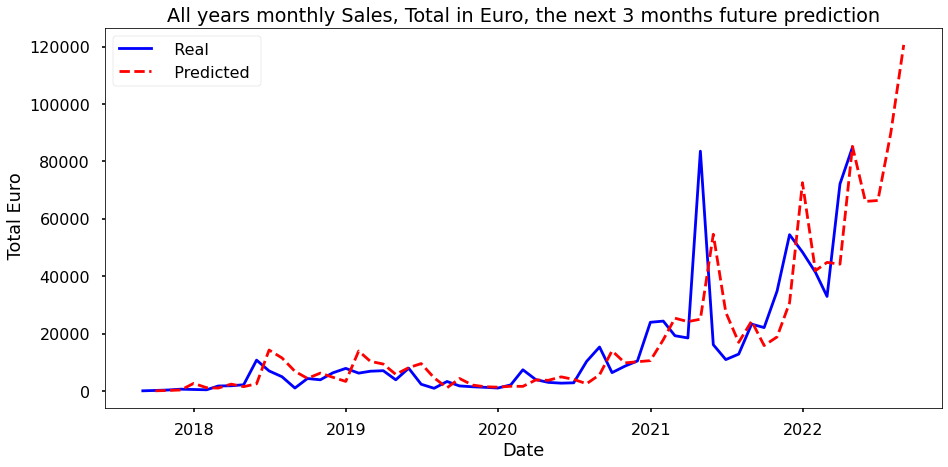

In [117]:
# Prediction
test=df_month['Total'];start=1; end=Length+3
ttitle='All years monthly Sales, Total in Euro, the next 3 months future prediction'
predict(test,date_list,start,end,ttitle)

## Deployment

In [118]:
# model saving
best_model.save("/content/drive/MyDrive/ColabNotebooks/Internship/Group2/Deployment_Files/ARIMA_best_model_monthly.pkl")
test=pd.DataFrame(test)
test.to_csv("/content/drive/MyDrive/ColabNotebooks/Internship/Group2/Deployment_Files/ARIMA_test_monthly.csv")
df_month["Total"].to_csv("/content/drive/MyDrive/ColabNotebooks/Internship/Group2/Deployment_Files/ARIMA_train_monthly.csv")



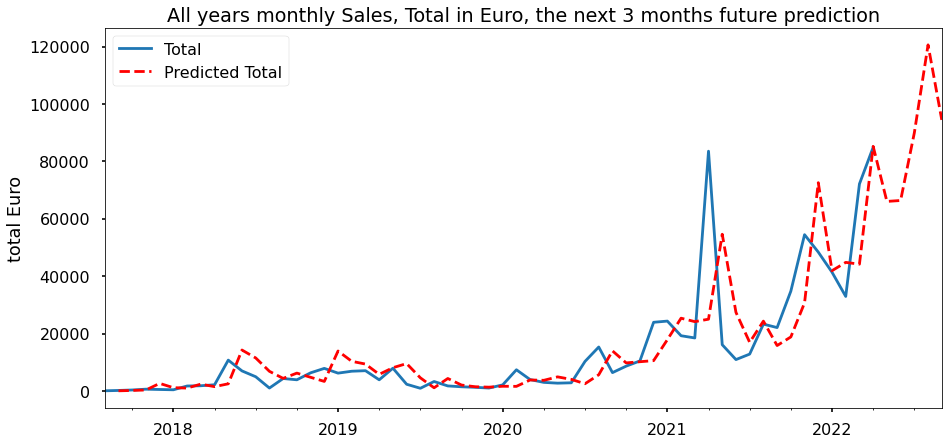

In [119]:
test=df_month[['Total']]
future = pd.DataFrame(index=date_list, columns= test.columns)
test_ = pd.concat([test, future])
length=len(df_day) 

test_['predicted'] = invboxcox(best_model.predict(start=1, end=length+3), lmbda)
plt.figure(figsize=(15,7))
test_.Total.plot()
test_.predicted.plot(color='r', ls='--', label='Predicted Total')
plt.legend()
plt.title('All years monthly Sales, Total in Euro, the next 3 months future prediction')
plt.ylabel('total Euro')
plt.show()

In [120]:
test_.to_csv("/content/drive/MyDrive/ColabNotebooks/Internship/Group2/Deployment_Files/ARIMA_test_monthly_all.csv")

# Total sales prediction by week.

In [121]:
df_week.isnull().sum()

Total    0
dtype: int64

<Figure size 1080x504 with 0 Axes>

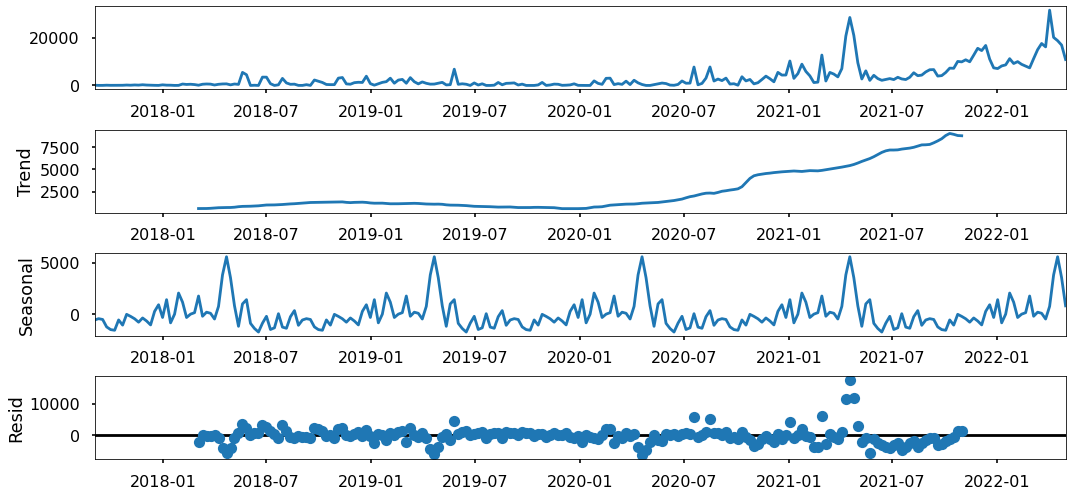

Dickey–Fuller test: p=0.887958


In [122]:
## Stationarity check and STL-decomposition of the series
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(df_week).plot()
plt.show()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_week)[1])

####Seriler durağan değil

In [123]:
round(df_week.describe(),)

,Total
count,244.0
mean,3263.0
std,4961.0
min,1.0
25%,310.0
50%,1052.0
75%,3937.0
max,31447.0


In [124]:
df_week

,Total
Date,
2017-09-03,94.48
2017-09-10,21.16
2017-09-17,26.37
2017-09-24,99.08
2017-10-01,45.46
...,...
2022-04-03,31446.96
2022-04-10,20069.80
2022-04-17,18706.04


In [125]:
# Box-Cox Transformations
df_week['Total_box'], lmbda = stats.boxcox(df_week.Total)
df_week.tail(2)

,Total,Total_box
Date,,
2022-04-24,16863.31,28.182713
2022-05-01,10824.76,25.481131


In [126]:
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_week.Total_box)[1])

Dickey–Fuller test: p=0.912371


#### Seriler durağan değil

<Figure size 1080x504 with 0 Axes>

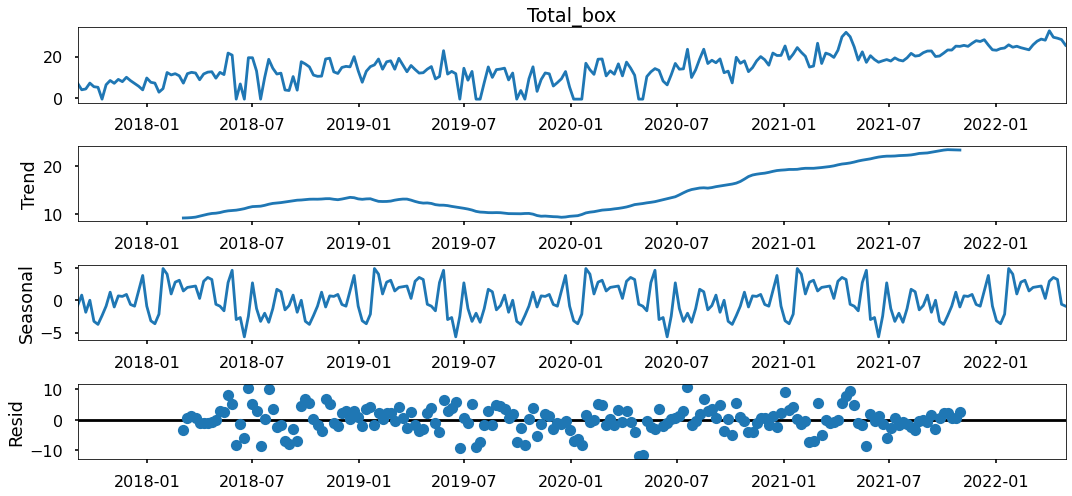

In [127]:
# STL-decomposition
plt.figure(figsize=(15,7))
sm.tsa.seasonal_decompose(df_week.Total_box).plot()   
plt.show()

In [128]:
# Seasonal differentiation
df_week['Total_box_diff'] = df_week.Total_box - df_week.Total_box.shift(7)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_week.Total_box_diff[7:])[1])

Dickey–Fuller test: p=0.000002


#### Seriler şimdi durağan hale geldi


In [129]:
df_week.head(8)

,Total,Total_box,Total_box_diff
Date,,,
2017-09-03,94.48,7.226612,NaN
2017-09-10,21.16,4.136048,NaN
2017-09-17,26.37,4.537465,NaN
2017-09-24,99.08,7.339934,NaN
2017-10-01,45.46,5.605882,NaN
2017-10-08,39.63,5.326123,NaN
2017-10-15,0.70,-0.344858,NaN
2017-10-22,70.60,6.554012,-0.6726


In [130]:
# Regular differentiation
# df_week['Total_box_diff2'] = df_week_box_diff - df_week_box_diff.shift(1)
# df_week.head(10)

In [131]:
len(df_week)

244

In [132]:
df_week.sort_index(inplace= True)

In [133]:
df_week.head()

,Total,Total_box,Total_box_diff
Date,,,
2017-09-03,94.48,7.226612,NaN
2017-09-10,21.16,4.136048,NaN
2017-09-17,26.37,4.537465,NaN
2017-09-24,99.08,7.339934,NaN
2017-10-01,45.46,5.605882,NaN


In [134]:
df_week.tail()

,Total,Total_box,Total_box_diff
Date,,,
2022-04-03,31446.96,32.386498,8.086958
2022-04-10,20069.80,29.307362,5.505919
2022-04-17,18706.04,28.848242,5.555599
2022-04-24,16863.31,28.182713,2.498965
2022-05-01,10824.76,25.481131,-1.944589


<Figure size 1080x504 with 0 Axes>

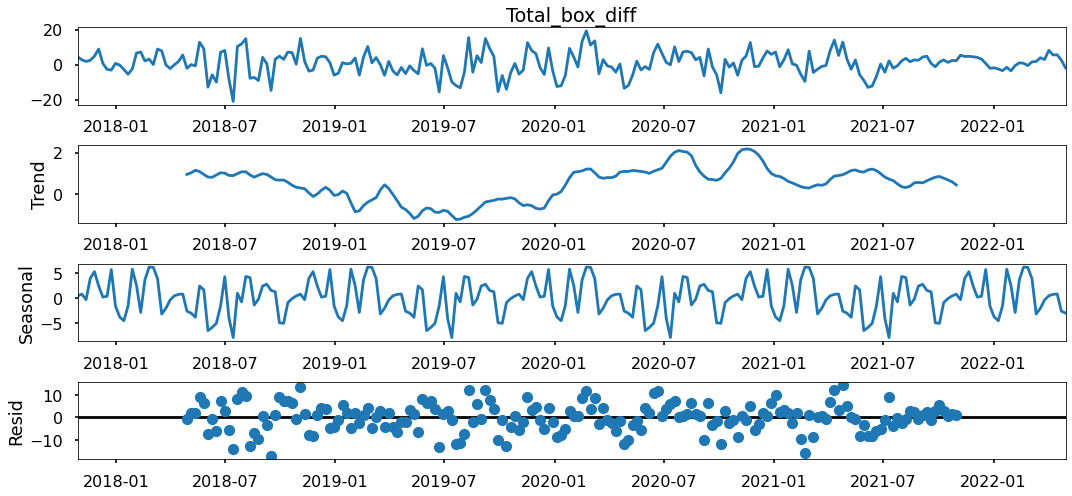

In [135]:
# STL-decomposition 
plt.figure(figsize=(15,7))
sm.tsa.seasonal_decompose(df_week.Total_box_diff[8:]).plot()   
plt.show()

In [136]:
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_week.Total_box_diff[8:])[1])

Dickey–Fuller test: p=0.000002


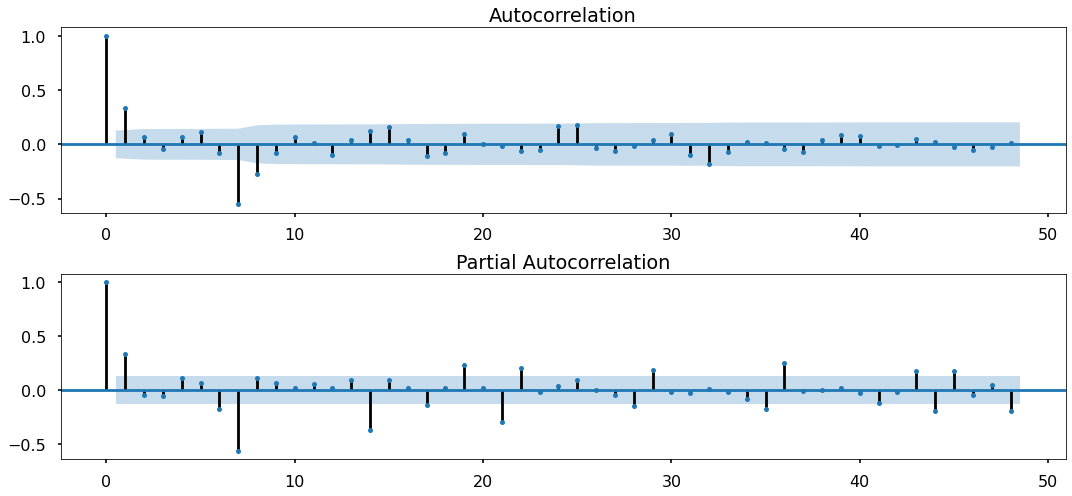

In [137]:
#### The series are stationary.
## ACF Autocorrelation Function Plot
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df_week.Total_box_diff[8:].values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df_week.Total_box_diff[8:].values.squeeze(), lags=48, ax=ax)
plt.tight_layout()
plt.show()

In [138]:
## Model Selection
# model_select(df_week.Total_box,5)

In [139]:
## Model Selection
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df_week.Total_box, order=(param[0], d, param[1]), 
              seasonal_order=(param[2], D, param[3], 5)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [140]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters          aic
25  (1, 1, 0, 1)  1406.710994
27  (1, 1, 1, 1)  1407.848968
43  (2, 1, 0, 1)  1408.213567
13  (0, 2, 0, 1)  1408.273274
31  (1, 2, 0, 1)  1408.422872
                                     SARIMAX Results                                     
Dep. Variable:                         Total_box   No. Observations:                  244
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 5)   Log Likelihood                -699.355
Date:                           Thu, 06 Oct 2022   AIC                           1406.711
Time:                                   17:35:59   BIC                           1420.600
Sample:                               09-03-2017   HQIC                          1412.309
                                    - 05-01-2022                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------

Dickey–Fuller test:: p=0.000000


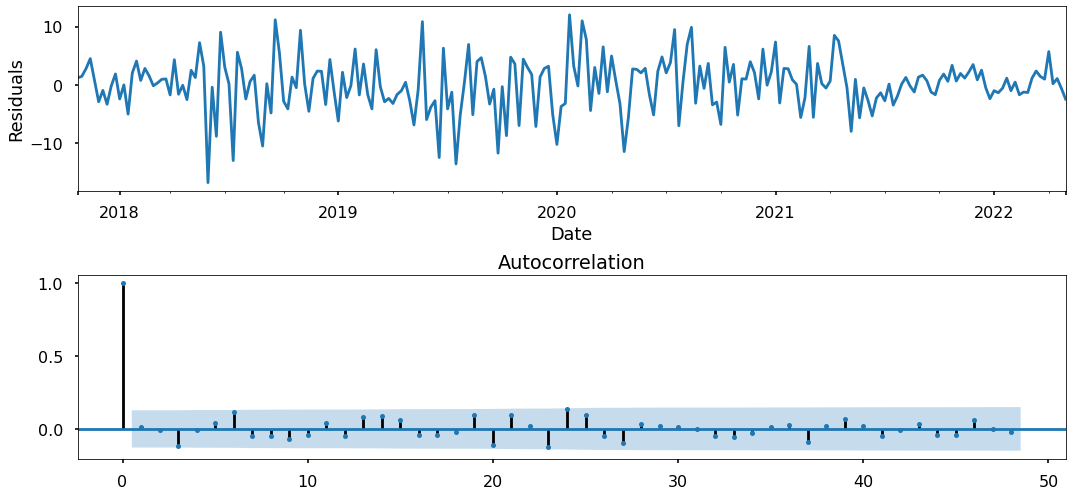

In [141]:
## Analysis of residues
# STL-decomposition
plt.figure(figsize=(15,7))
plt.subplot(211)
best_model.resid[8:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[8:].values.squeeze(), lags=48, ax=ax)

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

plt.tight_layout()
plt.show()

In [142]:
print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Dickey–Fuller test:: p=0.000000


# Prediction

## Inverse Box-Cox Transformation Function

In [143]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

In [144]:
Length=len(df_week)
Length

244

In [145]:
train=df_week

In [146]:
# Gelecek 3 ay(13hafta) için tarihleri oluşturalım.
last_day=(train.index[-1])   # date : the last day of test

# increase the day +7*1  (weekly) and 7*14 (3 months)
thenextday=last_day +datetime.timedelta(days=7)   #  the first day of the prediction day
thelastday=last_day +datetime.timedelta(days=7*13)    #   the last day of the prediction  day
date_list= pd.date_range(start=thenextday, end=thelastday, freq='W')

In [147]:
date_list

DatetimeIndex(['2022-05-08', '2022-05-15', '2022-05-22', '2022-05-29',
               '2022-06-05', '2022-06-12', '2022-06-19', '2022-06-26',
               '2022-07-03', '2022-07-10', '2022-07-17', '2022-07-24',
               '2022-07-31'],
              dtype='datetime64[ns]', freq='W-SUN')

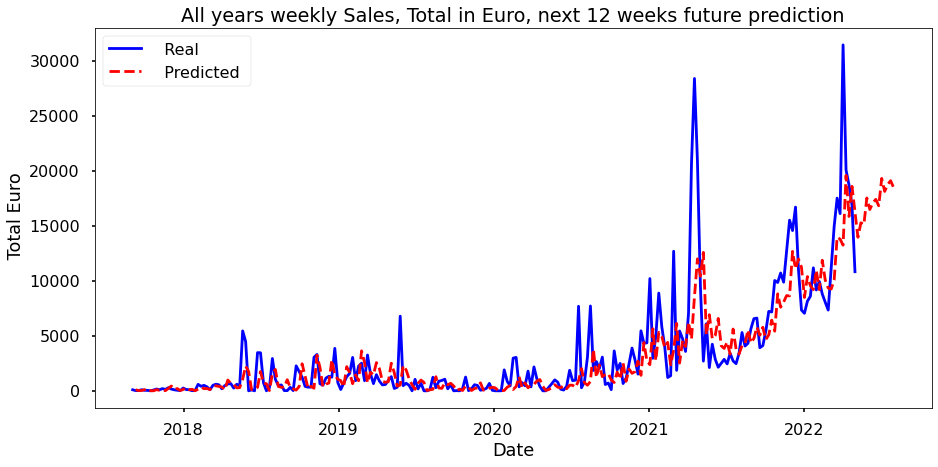

In [148]:
# Prediction for the next 12 weeks together with the THE ALL YEARS weekly data
test=df_week['Total']; start=1; end=Length+12
ttitle='All years weekly Sales, Total in Euro, next 12 weeks future prediction'
predict(test,date_list,start,end,ttitle)

In [149]:
# _train=aa.Total
# y_train_pred=bb.forecast
# evals_()

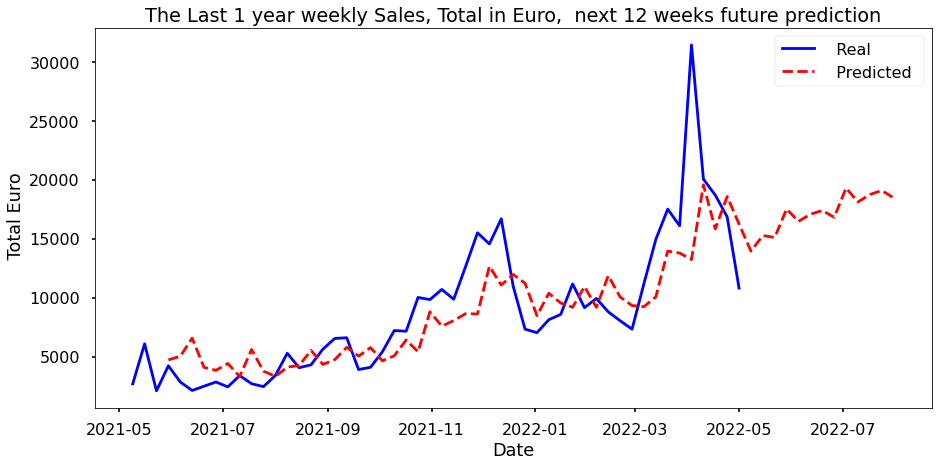

In [150]:
# Prediction for the next 12 weeks together with the THE LAST 1 YEAR weekly data
test=df_week['Total'][-52:]; start=195; end=Length+12; ttitle='The Last 1 year weekly Sales, Total in Euro,  next 12 weeks future prediction'
predict(test,date_list,start,end,ttitle)

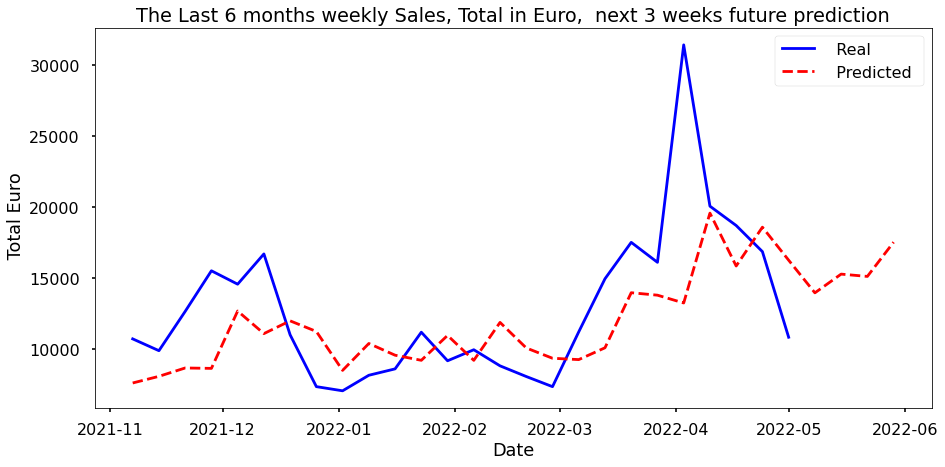

In [151]:
# Prediction for the next 3 weeks together with THE LAST 6 MONTHS
test=df_week['Total'][-26:]; start=Length-26; end=Length+3
ttitle='The Last 6 months weekly Sales, Total in Euro,  next 3 weeks future prediction'
predict(test,date_list,start,end,ttitle)

## Deployment

In [152]:
# model saving
best_model.save("/content/drive/MyDrive/ColabNotebooks/Internship/Group2/Deployment_Files/ARIMA_best_model_weekly.pkl")
test=pd.DataFrame(test)
test.to_csv("/content/drive/MyDrive/ColabNotebooks/Internship/Group2/Deployment_Files/ARIMA_test_weekly.csv")
df_week["Total"].to_csv("/content/drive/MyDrive/ColabNotebooks/Internship/Group2/Deployment_Files/ARIMA_train_weekly.csv")
test_.tail(10)

,Total,predicted
2021-12-31,48398.70,72581.857934
2022-01-31,41406.22,41922.077520
2022-02-28,32962.93,44818.865381
2022-03-31,72152.11,44195.861983
2022-04-30,84919.03,85230.467369
2022-05-31,NaN,66058.870612
2022-06-30,NaN,66378.637576
2022-07-31,NaN,89949.839261
2022-08-31,NaN,120591.704451
2022-09-30,NaN,94461.838414


In [153]:
test_.to_csv("/content/drive/MyDrive/Colab Notebooks/Internship/Group2/Deployment_Files/ARIMA_test_weekly_all.csv")

FileNotFoundError: ignored

In [ ]:
#df4[["Total","forecast"]].tail(5)   # The last 3 weeks are forecasted weeks

In [ ]:
#df4[["forecast"]].iloc[-3:,] # forecasted weeks


# Total sales prediction by day

In [ ]:
df_day.isnull().sum()

In [ ]:
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_day)[1])

####Seriler durağan

In [ ]:
df_day

In [ ]:
# Box-Cox Transformations
df_day['Total_box'], lmbda = stats.boxcox(df_day.Total)
df_day.tail(2)

In [ ]:
lmbda

In [ ]:
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_day.Total_box)[1])

#### Seriler durağan 

In [ ]:
## Seasonal differentiation
# Seasonal differentiation
df_day['Total_box_diff'] = df_day.Total_box - df_day.Total_box.shift(7)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_day.Total_box_diff[7:])[1])

In [ ]:
df_day.head(10)

#### Seriler daha durağan hale geldi


In [ ]:
## Regular differentiation
# Regular differentiation
# df_day['Total_box_diff2'] = df_day_box_diff - df_day_box_diff.shift(1)
# df_day.head(10)

In [ ]:
len(df_day)

In [ ]:
df_day.sort_index(inplace= True)

In [ ]:
df_day.head()

In [ ]:
df_day.tail()

In [ ]:
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_day.Total_box_diff[8:])[1])

In [ ]:
## Model Selection
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df_day.Total_box, order=(param[0], d, param[1]), 
              seasonal_order=(param[2], D, param[3], 5)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [ ]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

In [ ]:
print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

# Prediction

## Inverse Box-Cox Transformation Function

In [ ]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

In [ ]:
Length=len(df_day)
Length

In [ ]:
last_day=(df_day.index[-1])   # date : the last day of train
last_day

In [ ]:
thenextday=last_day +datetime.timedelta(days=1)  
thenextday 

In [ ]:
thelastday=last_day +datetime.timedelta(days=93)  
thelastday 

In [ ]:
# Gelecek 3 ay için tarihlerden bir dataframe oluşturalım.
date_list= pd.date_range(start=thenextday, end=thelastday, freq='D')
date_list

In [ ]:
# Prediction for the next 3 months together with THE ALL YEARS data
test=df_day['Total']; start=1; end=Length+90; ttitle='All years daily Sales, Total in Euro,  next 3 months future prediction'
predict(test,date_list,start,end,ttitle)

In [ ]:
#y_train=df2.Total
#y_train_pred=df2.forecast
#evals_()

In [ ]:
# Prediction for the next  month together with THE LAST 3 MONTHS data
test=df_day['Total'][-90:]; start=Length-90; end=Length+30; ttitle='The last 3 months daily Sales, Total in Euro,  next  month  future prediction'
predict(test,date_list,start,end,ttitle)

In [ ]:
#y_train=df3.Total
#y_train_pred=df3.forecast
#evals_()

In [ ]:
# 'The last months daily Sales, Total in Euro,  next week future prediction'
test=df_day['Total'][-30:]; start=Length-30; end=Length+7; ttitle='The last months daily Sales, Total in Euro,  next week future prediction'
predict(test,date_list,start,end,ttitle)

In [ ]:
# y_train=df4.Total[:-5]
#y_train_pred=df4.forecast[:-5]
# evals_()

In [ ]:
# round(df4[["Total","forecast"]].tail(7))   # The next 5 day are forecasted 

In [ ]:
# round(df4[["forecast"]].iloc[-5:,]) # forecasted days


### SONUÇ: Geçmiş kayıtlar kullanılarak ileri yönlü tahmin yapma imkanı vardır.

### Deployment

In [ ]:
# model saving
best_model.save("/content/drive/MyDrive/Colab Notebooks/Internship/Group2/Deployment_Files/ARIMA_best_model_daily.pkl")
test=pd.DataFrame(test)
test.to_csv("/content/drive/MyDrive/Colab Notebooks/Internship/Group2/Deployment_Files/ARIMA_test_daily.csv" )
df_day.to_csv("/content/drive/MyDrive/Colab Notebooks/Internship/Group2/Deployment_Files/ARIMA_train_daily.csv" )
	

# CHECK

In [ ]:
# MONTHLY record
#'All years monthly Sales, Total in Euro, the next 3 months future prediction'
def invboxcox(y,lmbda):
    if lmbda == 0:
            return(np.exp(y))
    else:
           return(np.exp(np.log(lmbda*y+1)/lmbda))

arima_best_model=ARIMAResults.load("/content/drive/MyDrive/Colab Notebooks/Internship/Group2/Deployment_Files/ARIMA_best_model_monthly.pkl")         
df_month=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Internship/Group2/Deployment_Files/ARIMA_train_monthly.csv").set_index("Date")
test=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Internship/Group2/Deployment_Files/ARIMA_test_monthly.csv").set_index("Date")   

test.index = pd.to_datetime(test.index)
last_record=(test.index[-1])       # date : the last month of test

import datetime
from datetime import timedelta
# increase the month +1  (monthly)
thenextday=last_record +datetime.timedelta(days=30)   #  the first month of the prediction day
thelastday=last_record +datetime.timedelta(days=6*30)    #   the last month of the prediction  day
    
# Gelecek 6 ay  için tarihleri oluşturalım.
date_list= pd.date_range(start=thenextday, end=thelastday, freq='M')

future = pd.DataFrame(index=date_list, columns= test.columns)
test_ = pd.concat([test, future])
length=len(df_month)
df_month['Total_box'], lmbda = stats.boxcox(df_month.Total)   # To calculate the "lmbda"
 
test_['predicted'] = invboxcox(arima_best_model.predict(start=1, end=length+6), lmbda)
result=test_["predicted"][-6]
result_avg=test_["predicted"][-6:].mean()

plt.figure(figsize=(15,7))
test_.Total.plot()
test_.predicted.plot(color='r', ls='--', label='Predicted Total')
plt.legend()
plt.title('The Last 1 year weekly Sales, Total in Euro,  next 12 weeks future prediction')
plt.ylabel('total Euro')
plt.show()    
    
#test_ = test_.resample('M').sum().astype('int')        # to prevent the floating numbers after dot (.)
#test_.index = pd.to_datetime(test_.index).date         # only to show the date not date&time

In [ ]:
# WEEKLY records
# 'The Last 1 year weekly Sales, Total in Euro,  next 12 weeks future prediction'
def invboxcox(y,lmbda):
     if lmbda == 0:
          return(np.exp(y))
     else:
          return(np.exp(np.log(lmbda*y+1)/lmbda))

arima_best_model=ARIMAResults.load("/content/drive/MyDrive/Colab Notebooks/Internship/Group2/Deployment_Files/ARIMA_best_model_weekly.pkl")         
df_week=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Internship/Group2/Deployment_Files/ARIMA_train_weekly.csv").set_index("Date") 
test=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Internship/Group2/Deployment_Files/ARIMA_test_weekly.csv").set_index("Date")  

test.index = pd.to_datetime(test.index)

# Gelecek 3 ay(12hafta) için tarihleri oluşturalım.
import datetime
last_day=(test.index[-1])   # date : the last day of test

# increase the day +7  (weekly)
thenextday=last_day +datetime.timedelta(days=7)   #  the first day of the prediction day
thelastday=last_day +datetime.timedelta(days=7*12)    #   the last day of the prediction  day
date_list= pd.date_range(start=thenextday, end=thelastday, freq='W')

future = pd.DataFrame(index=date_list, columns= test.columns)
test_ = pd.concat([test, future])
length=len(df_week)
df_week['Total_box'], lmbda = stats.boxcox(df_week.Total)

test_['predicted'] = invboxcox(arima_best_model.predict(start=1, end=length+12), lmbda)
test_['predicted']=test_['predicted'].astype('int') 
result=test_["predicted"][-7]

plt.figure(figsize=(15,7))
test_.Total.plot()
test_.predicted.plot(color='r', ls='--', label='Predicted Total')
plt.legend()
plt.title('The Last 1 year weekly Sales, Total in Euro,  next 12 weeks future prediction')
plt.ylabel('total Euro')
plt.show()


In [ ]:
# DAILY records

def invboxcox(y,lmbda):
    if lmbda == 0:
       return(np.exp(y))
    else:
         return(np.exp(np.log(lmbda*y+1)/lmbda))

arima_best_model=ARIMAResults.load("/content/drive/MyDrive/Colab Notebooks/Internship/Group2/Deployment_Files/ARIMA_best_model_daily.pkl")      
df_day=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Internship/Group2/Deployment_Files/ARIMA_train_daily.csv").set_index("Date")
df_day['Total_box'], lmbda = stats.boxcox(df_day.Total)

test=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Internship/Group2/Deployment_Files/ARIMA_test_daily.csv").set_index("Date")  
test.index = pd.to_datetime(test.index)
last_day=(test.index[-1])   # date : the last day of test
  
import datetime
# increase the day +1
thenextday=last_day +datetime.timedelta(days=1)   #  the first day of the prediction day
thelastday=last_day +datetime.timedelta(days=7)    #   the last day of the prediction  day
    
# Lets produce the next 1 weeks datatime series
date_list= pd.date_range(start=thenextday, end=thelastday, freq='D')

future = pd.DataFrame(index=date_list, columns= test.columns)
test_ = pd.concat([test, future])
length=len(df_day) 

test_['predicted'] = invboxcox(arima_best_model.predict(start=length-30, end=length+7), lmbda)
result=test_["predicted"][-7]
result_avg=test_["predicted"][-7:].mean()


plt.figure(figsize=(15,7))
test_.Total.plot()
test_.predicted.plot(color='r', ls='--', label='Predicted Total')
plt.legend()
plt.title('The Last 1 year weekly Sales, Total in Euro,  next 12 weeks future prediction')
plt.ylabel('total Euro')
plt.show()

#test_ = test_.resample('D').sum().astype('int')  # to prevent the floating numbers after dot (.)
#test_.index = pd.to_datetime(test_.index).date  # only to show the date not date&time
    

